ADF Statistic: -8.181083850355474
p-value: 8.128023336675245e-13
Critical Values: {'1%': -3.4318524474416483, '5%': -2.862203897664062, '10%': -2.5671233972458647}
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
RMSE: 243027.7545795857


c:\Users\saran\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\saran\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


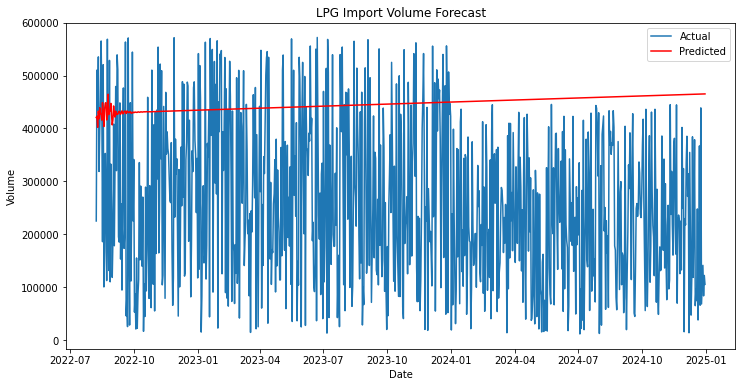

c:\Users\saran\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


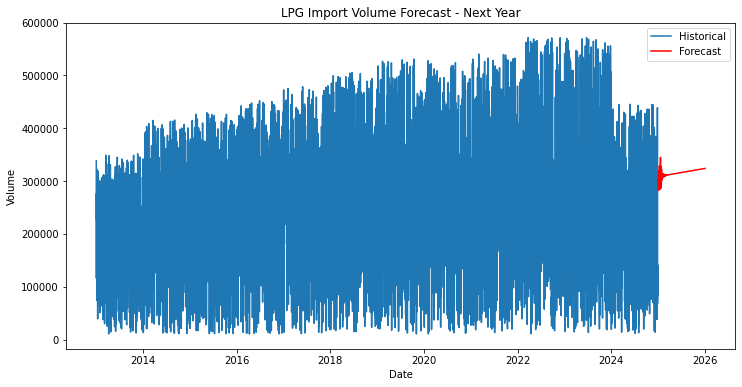

Forecasted values for the next 365 days:
                 date  forecasted_volume
2022-08-08 2025-01-01      300959.566871
2022-08-09 2025-01-02      303529.582225
2022-08-10 2025-01-03      282391.269592
2022-08-11 2025-01-04      312834.410936
2022-08-12 2025-01-05      298351.198524
...               ...                ...
2023-08-03 2025-12-27      323826.734596
2023-08-04 2025-12-28      323868.856560
2023-08-05 2025-12-29      323910.978524
2023-08-06 2025-12-30      323953.100488
2023-08-07 2025-12-31      323995.222452

[365 rows x 2 columns]


In [5]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# Load the data
# Assuming your data is in a CSV file with columns 'date' and 'LPG Imports(Modified)'
df = pd.read_csv('./data/LPG_Random_Daily_Import_Volumes.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Check for stationarity
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

test_stationarity(df['LPG Imports(Modified)'])

# If data is non-stationary, consider differencing
df['volume_diff'] = df['LPG Imports(Modified)'].diff()
df = df.dropna()

# Split the data into train and test sets
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Fit the AutoRegressive model
model = AutoReg(train['volume_diff'], lags=30)  # You can adjust the lag value
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=len(test))

# Convert differences back to original scale
predictions_cumsum = predictions.cumsum()
predictions_volume = test['LPG Imports(Modified)'].iloc[0] + predictions_cumsum

# Evaluate the model
rmse = sqrt(mean_squared_error(test['LPG Imports(Modified)'], predictions_volume))
print(f'RMSE: {rmse}')

# Plot the results
plt.figure(figsize=(12,6))
plt.plot(test.index, test['LPG Imports(Modified)'], label='Actual')
plt.plot(test.index, predictions_volume, color='red', label='Predicted')
plt.title('LPG Import Volume Forecast')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

# Forecast future values (e.g., next 365 days)
future_forecast = model_fit.forecast(steps=365)
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=365)

future_forecast_cumsum = future_forecast.cumsum()
future_forecast_volume = df['LPG Imports(Modified)'].iloc[-1] + future_forecast_cumsum

plt.figure(figsize=(12,6))
plt.plot(df.index, df['LPG Imports(Modified)'], label='Historical')
plt.plot(future_dates, future_forecast_volume, color='red', label='Forecast')
plt.title('LPG Import Volume Forecast - Next Year')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

print("Forecasted values for the next 365 days:")
future_forecast_df = pd.DataFrame({'date': future_dates, 'forecasted_volume': future_forecast_volume})
print(future_forecast_df)